<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/09/0910.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install umap-learn[plot]

## Clustering iris and digits

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score

from sklearn.datasets import load_iris
from sklearn.datasets import fetch_openml

from scipy.cluster.hierarchy import linkage, fcluster

import umap
import umap.plot as uplot

plt.rcParams['figure.figsize'] = [9, 5]
sns.set_theme()

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:61: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-p

In [3]:
# Load iris dataset
iris = load_iris()

# Load iris dataset
iris_df = pd.DataFrame(
    iris['data'],
    columns=iris['feature_names']
)

numer_cols = iris_df.columns

# Load iris label
iris_df['label'] = iris['target_names'][iris['target']]

Text(0.5, 1.0, 'Scatterplot with true label')

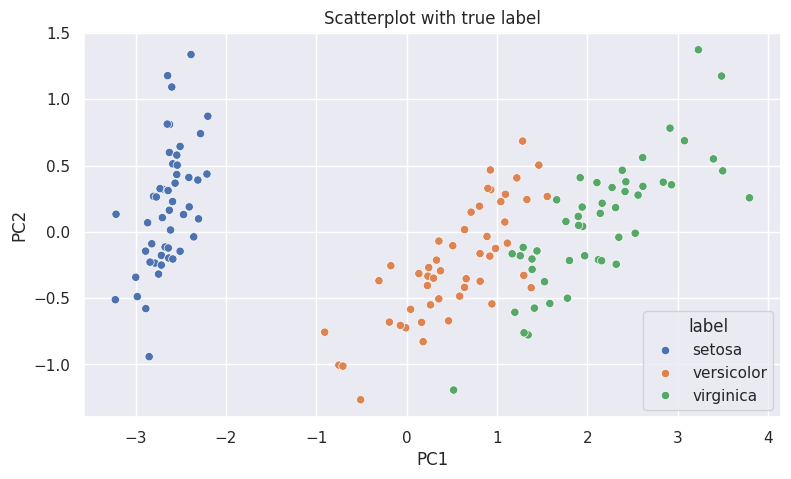

In [4]:
# Run PCA so we can show dataset in 2D space
pca = PCA(n_components=2)
pca_data = pca.fit_transform(iris_df[numer_cols].values)
pca_data = np.column_stack([pca_data, iris_df['label'].values])
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2', 'label'])

# Plot and colour based on reference label
sns.scatterplot(pca_df, x='PC1', y='PC2', hue='label')
plt.title('Scatterplot with true label')

ARI : 0.7163421126838476


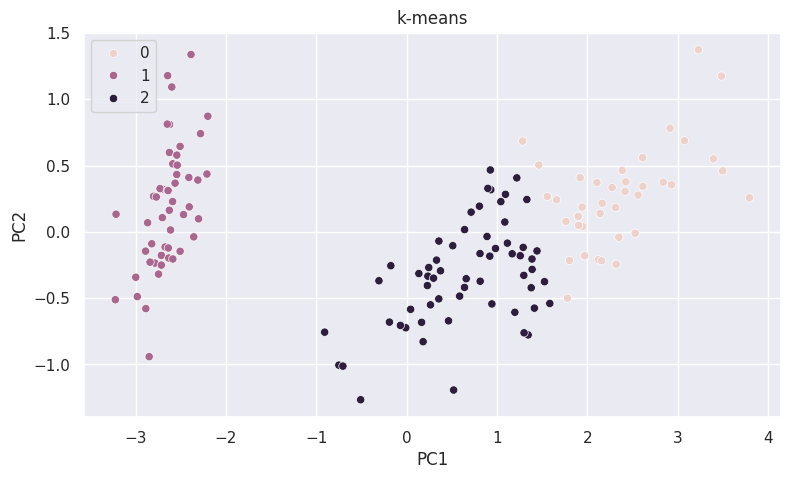

In [5]:
kmeans = KMeans(n_clusters=3, n_init='auto')
kmeans.fit(iris_df[numer_cols])

ari = adjusted_rand_score(
    iris_df['label'].to_numpy(),
    kmeans.labels_
)

print('ARI : ' + str(ari))

plt.figure()
sns.scatterplot(pca_df, x='PC1', y='PC2', hue=kmeans.labels_)
plt.title('k-means')
plt.show()

ARI : 0.5637510205230709


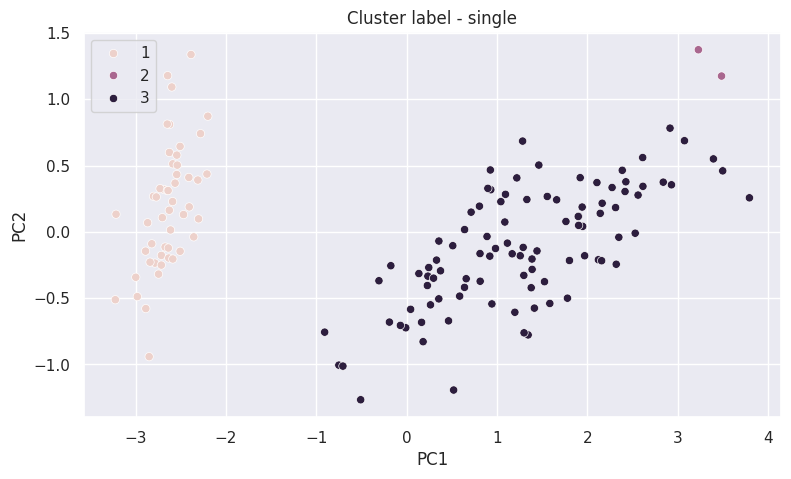

ARI : 0.6422512518362898


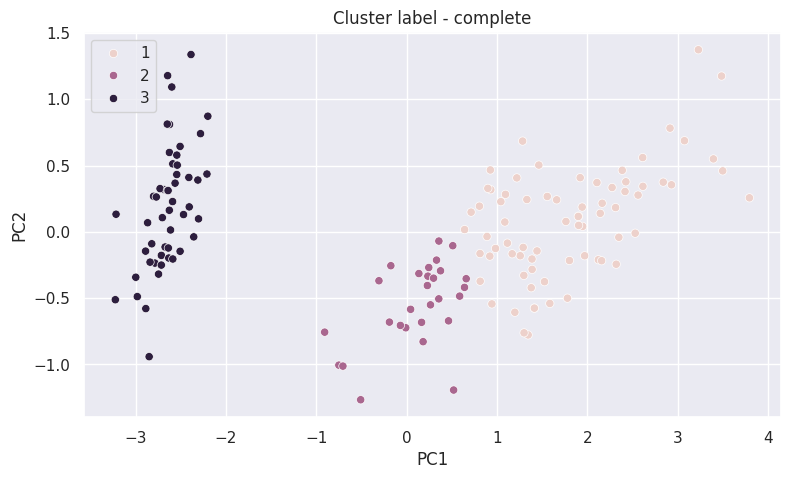

ARI : 0.7591987071071522


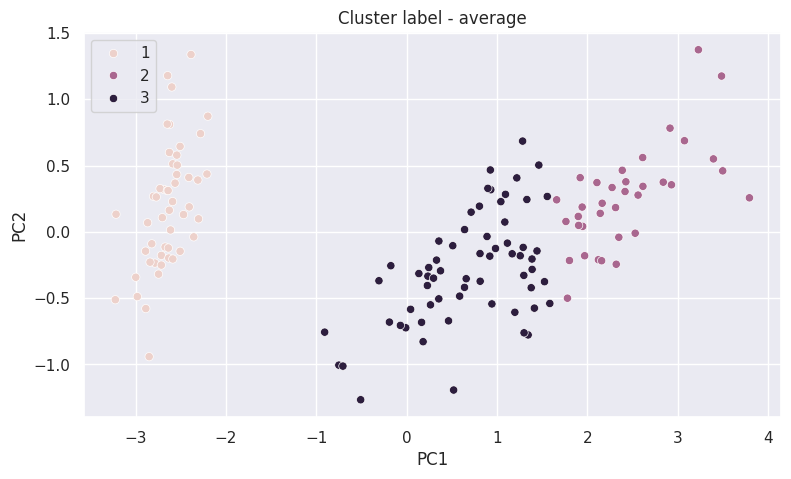

ARI : 0.7311985567707746


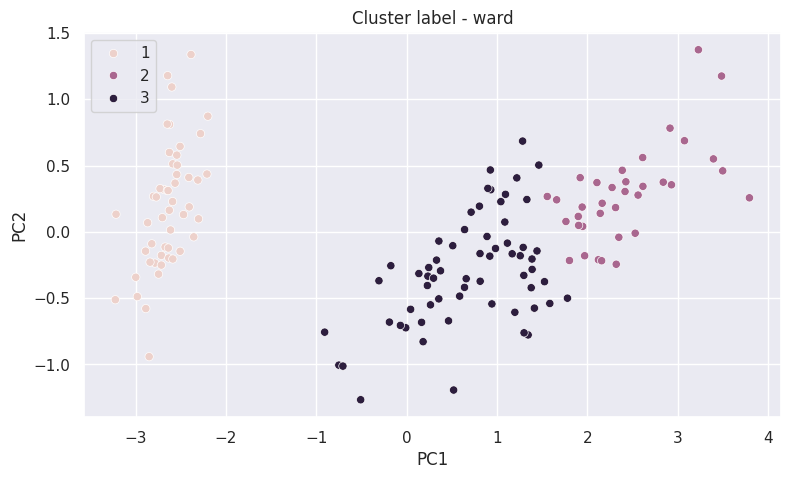

In [6]:
methods = ['single', 'complete', 'average', 'ward']

for method in methods:
    linkage_matrix = linkage(iris_df[numer_cols], method=method)
    clusters = fcluster(linkage_matrix, t=3, criterion='maxclust')

    ari = adjusted_rand_score(
        iris_df['label'].to_numpy(),
        clusters
    )

    print('ARI : ' + str(ari))

    # Plot and colour based on reference label
    plt.figure()
    sns.scatterplot(pca_df, x='PC1', y='PC2', hue=clusters)
    plt.title('Cluster label - ' + method)
    plt.show()
# single: this type of behavior is a direct result of a chaining effect
# complete: ARI is a bit better
# average: even better separation
# ward: similar result as average case
# even for the ward linkage, the separation is not perfect
# given the nature of agglomerative clustering and the nature of this data set,
# this is kind of expected because we have two groups having instances that are pretty similar to each other
# due to the nature of agglomerative clustering, a certain mixup can happen

## Digits dataset

In [8]:
# Load digits data
mnist = fetch_openml('mnist_784', parser='auto')

# Normalize digits data
digits_data = mnist.data/255
digit_labels = mnist.target

# Subset the dataset
# if we were using the original size, the agglomerative clustering algorithm would struggle
digit_labels_df = pd.DataFrame(digit_labels)

label_subset_df = digit_labels_df.groupby('class').head(500)

digits_data = digits_data.loc[label_subset_df.index, :].reset_index(drop=True)
digit_labels = label_subset_df['class'].to_numpy()

<Axes: >

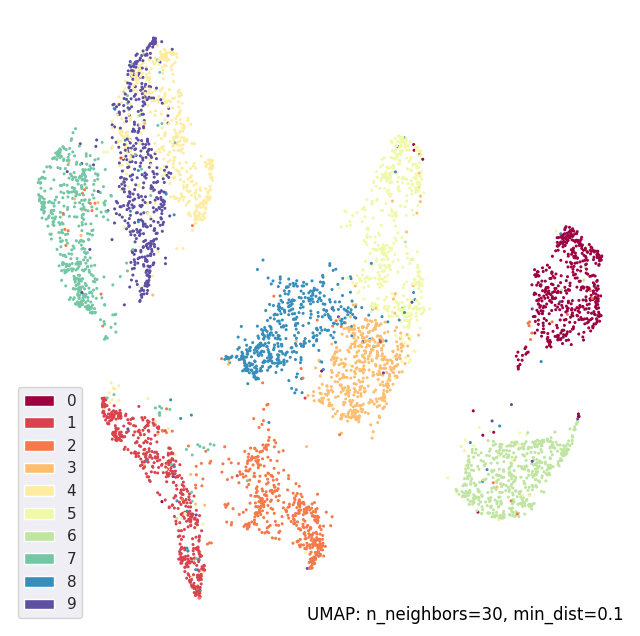

In [9]:
# Embed dataset
mnist_umap = umap.UMAP(n_neighbors=30)
embedding = mnist_umap.fit_transform(digits_data)

# Plot 2D embedding
uplot.points(mnist_umap, labels=digit_labels)

ARI = 0.2975391582801035


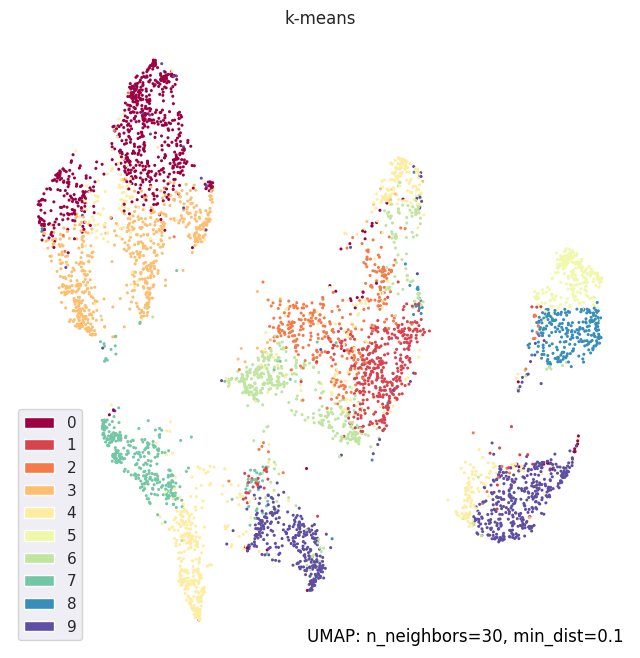

In [10]:
kmeans = KMeans(n_clusters=10, n_init='auto')
kmeans.fit(digits_data)

print('ARI = {}'.format(adjusted_rand_score(kmeans.labels_, digit_labels)))
uplot.points(mnist_umap, labels=kmeans.labels_)
_ = plt.title('k-means')

ARI = 7.249519851737537e-08


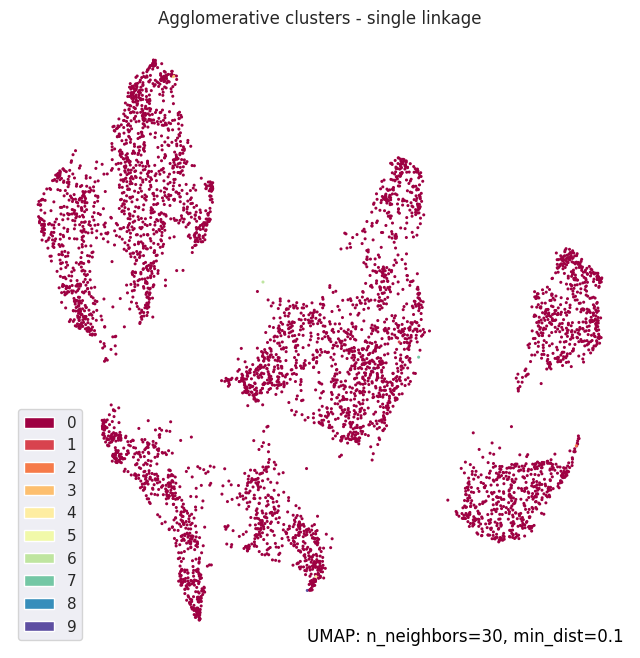

In [11]:
# Perform hierarchical clustering for single linkage
clustering = AgglomerativeClustering(
    n_clusters=10, linkage='single',
).fit(digits_data)

print('ARI = {}'.format(adjusted_rand_score(clustering.labels_, digit_labels)))
uplot.points(mnist_umap, labels=clustering.labels_)
_ = plt.title('Agglomerative clusters - single linkage')
# the majority of data points belong to a single cluster, which is a direct result of a chaining effect

ARI = 0.15777822431598285


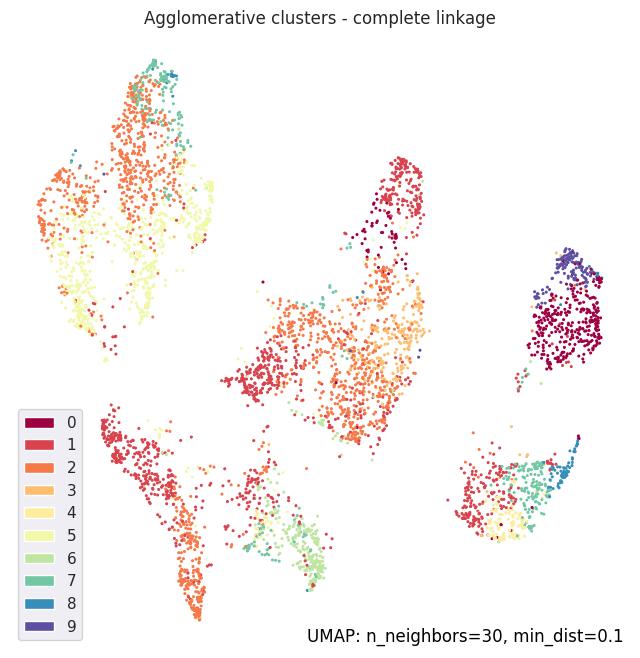

In [12]:
# Perform hierarchical clustering with complete linkage
clustering = AgglomerativeClustering(
    n_clusters=10, linkage='complete'
).fit(digits_data)

print('ARI = {}'.format(adjusted_rand_score(clustering.labels_, digit_labels)))
uplot.points(mnist_umap, labels=clustering.labels_)
_ = plt.title('Agglomerative clusters - complete linkage')
# this clustering is pretty messy
# still we have adjusted rand score that is pretty low and moving to more sophisticated methods

ARI = 0.04417339487518105


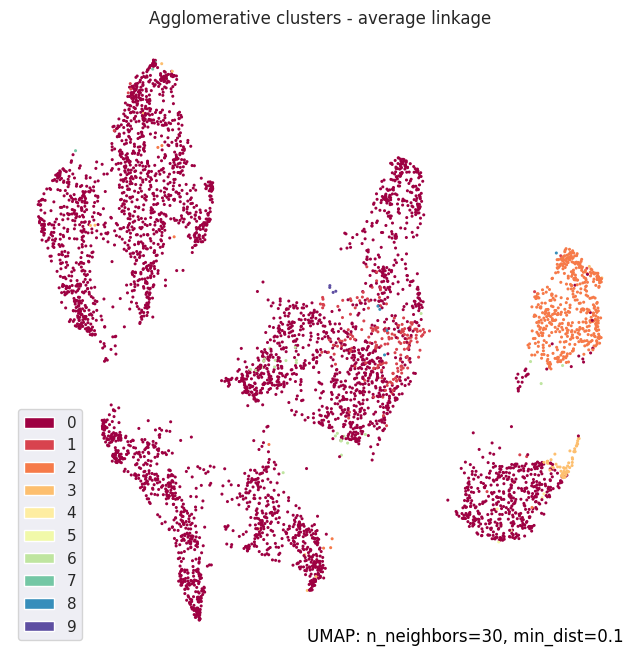

In [13]:
# Perform hierarchical clustering with average linkage
clustering = AgglomerativeClustering(
    n_clusters=10, linkage='average'
).fit(digits_data)

print('ARI = {}'.format(adjusted_rand_score(clustering.labels_, digit_labels)))
uplot.points(mnist_umap, labels=clustering.labels_)
_ = plt.title('Agglomerative clusters - average linkage')
# we have the chaining effect here, which can happen with the average linkage when the data is very noisy

ARI = 0.5016084210255642


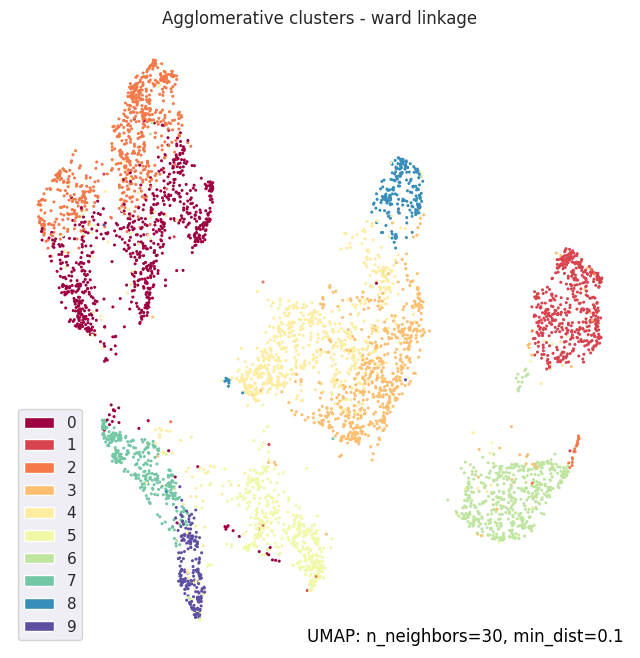

In [14]:
# Perform hierarchical clustering with ward linkage
clustering = AgglomerativeClustering(
    n_clusters=10, linkage='ward'
).fit(digits_data)

print('ARI = {}'.format(adjusted_rand_score(clustering.labels_, digit_labels)))
uplot.points(mnist_umap, labels=clustering.labels_)
_ = plt.title('Agglomerative clusters - ward linkage')
# the ward linkage has managed to cluster this data to some extent